<center><h1>StreamSoNG (Streaming Soft Neural Gas)</h1></center>

<hr />

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X1 = np.random.normal(-2, 2,(100, 2))
Y1 = np.zeros(len(X1))
X2 = np.random.normal(15, 4,(100, 2))
Y2 = np.zeros(len(X2)) + 1
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

X.shape, Y.shape

((200, 2), (200,))

In [3]:
C = len(np.unique(Y))
"C", C

('C', 2)

# Neural Gas (NG)

In [4]:
class NeuralGas():
    def __init__(self, num_prototypes, dimension, step_size, neighborhood_range):
        self.num_prototypes = num_prototypes
        self.dimension = dimension
#         self.prototypes = np.random.random((num_prototypes, dimension))
        self.prototypes = np.random.normal(0, 4, (num_prototypes, dimension))
        self.prototype_labels = np.full(num_prototypes, np.nan)
        self.step_size = step_size
        self.neighborhood_range = neighborhood_range
    
    def initialize_prototypes(self, X, Y):
        indices = np.random.choice(len(X), self.num_prototypes)
        for i in range(len(indices)):
            self.prototypes[i] = X[indices[i]]
            self.prototype_labels[i] = Y[indices[i]]
    
    def visualize(self, X, Y):
        fig, ax = plt.subplots()
        
        # data
        ax.scatter(X[:, 0], X[:, 1], label="data", c=Y, cmap="Pastel1")
        
        # prototypes
        ax.scatter(self.prototypes[:, 0], self.prototypes[:, 1], c=self.prototype_labels, cmap="Set1", label="prototypes", marker="x")
        
        plt.show()
        
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def learn(self, X):
        idx = np.random.choice(len(X))
        x = X[idx]
        
        distances = np.zeros(self.num_prototypes)
        for i in range(len(distances)):
            distances[i] = self.get_distance(x, self.prototypes[i])
        indices = np.argsort(distances)
        
        for k, i in enumerate(indices, 1):
            delta = self.step_size * np.exp(-k / self.neighborhood_range) * (x - self.prototypes[i])
            self.prototypes[i] += delta

In [5]:
num_prototypes = 5
dimension = 2
prototypes = []
prototype_labels = []

for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ng = NeuralGas(num_prototypes=num_prototypes, dimension=dimension, step_size=0.01, neighborhood_range=2)
    ng.initialize_prototypes(X_c, Y_c)
    for epoch in range(20):
        ng.learn(X)
    prototypes.extend(ng.prototypes)
    prototype_labels.extend(ng.prototype_labels)

prototypes = np.array(prototypes)
prototype_labels = np.array(prototype_labels)
print(prototypes.shape, prototype_labels.shape)

(10, 2) (10,)


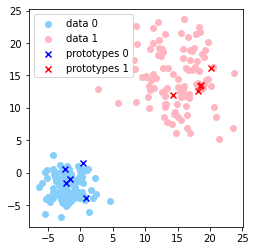

In [6]:
data_colors = ("lightskyblue", "lightpink")
prototype_colors = ("blue", "red")

fig, ax = plt.subplots()

# data
for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ax.scatter(X_c[:, 0], X_c[:, 1], label=f"data {c}", color=data_colors[c])
    
# prototypes
for c in range(C):
    indices = np.where(prototype_labels == c)
    prototypes_c = prototypes[indices]
    ax.scatter(prototypes_c[:, 0], prototypes_c[:, 1], c=prototype_colors[c], label=f"prototypes {c}", marker="x")

ax.set_aspect(1)
plt.legend()
plt.show()

In [7]:
prototypes.shape

(10, 2)

# Probabilistic K-Nearest Neighbors (PKNN)

In [8]:
class PKNN():
    def __init__(self, prototypes, prototype_labels, num_classes, K, fuzzifier):
        self.prototypes = prototypes
        self.prototype_labels = prototype_labels.astype(int)
        self.num_classes = num_classes
        self.K = K
        self.fuzzifier = fuzzifier
    
    def add_prototypes(self, new_prototypes):
#         self.prototypes = np.append(self.prototypes, new_prototypes, axis=0)
        self.prototypes = np.concatenate((self.prototypes, new_prototypes))
        
    def add_prototype_labels(self, new_prototype_labels):
#         self.prototype_labels = np.append(self.prototype_labels, new_prototype_labels).astype(int)
        self.prototype_labels = np.concatenate((self.prototype_labels, new_prototype_labels)).astype(int)
    
    def add_class(self):
        self.num_classes += 1
    
    def num_prototypes(self):
        return self.prototypes.shape[0]
    
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum(np.power(a - b, 2)))
    
    def knn(self, A, B, n=5, ignore_diag=False, distance_fx=None):
        if A.ndim == 1:
            A = A[None, :]
        if distance_fx is None:
            distance_fx = self.get_distance
        distances = np.full((len(A), len(B)), np.nan)
        for i in range(len(A)):
            for j in range(len(B)):
                if ignore_diag and i == j:
                    continue
                distances[i, j] = distance_fx(A[i], B[j])
            
        sorted_indices = np.argpartition(distances, kth=range(n), axis=1)[:, :n]
        shortest_distances= np.full((len(A), n), np.nan)
        for i in range(len(shortest_distances)):
            shortest_distances[i] = distances[i, sorted_indices[i]]
        return sorted_indices, shortest_distances
        
    def estimate_radius(self, n=5, show_figure=False):
        if n >= self.num_prototypes():
            raise ValueError(f"n({n}) must be less than the number of prototypes({self.num_prototypes()})")
        self.radius = np.full(self.num_classes, np.nan)
        for c in range(self.num_classes):
            indices_c = np.where(self.prototype_labels == c)
            prototypes_c = self.prototypes[indices_c]
            _, shortest_distances = self.knn(prototypes_c, prototypes_c, n=n, ignore_diag=True, distance_fx=self.euclidean_distance)
            
            hist, bins = np.histogram(shortest_distances, bins=8)
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            self.radius[c] = mean = np.mean(center)
            
            if show_figure:
                fig, ax = plt.subplots()
                ax.bar(center, hist, align='center', width=width)
                ax.plot([mean] * (np.max(hist)+1), np.arange(np.max(hist)+1), color="red")
                ax.set_title(f"Class {c} $\eta = {mean:.3f}$")
    
    def compute_fuzzy_membership(self, n_i, pred, actual):
        if pred == actual:
            return 0.51 + (n_i / self.K) * 0.49
        else:
            return (n_i / self.K) * 0.49
    
    def compute_typicality(self, x, p, i):
        return 1 / (1 + (self.get_distance(x, p) / self.radius[i]) ** (1 / (self.fuzzifier-1)))
    
    def fuzzy_typicality(self, mu, t):
        return mu * t

    def average_typicality(self, fuzzy_typicalities):
        if np.sum(fuzzy_typicalities) == 0:
            return 0
        return np.nan_to_num(np.mean(fuzzy_typicalities))

    def s_function(self, x, a=0, b=0.5, c=1):
        if x <= 0:
            return 0
        elif a < x and x <= b:
            return ((x - a)**2) / (2 * ((b - a)**2))
        elif b < x and x <= c:
            return (-((x - c)**2) / (2 * ((b - c)**2))) + 1
        elif x > c:
            return 1
    
    def predict(self, x, j):
        sorted_indices, _ = self.knn(x, self.prototypes, n=self.K)
        t = 0

        # crisp membership ========================================================
        crisp_memberships = np.zeros(self.num_classes) # n_i
        for i in self.prototype_labels[sorted_indices[t]]:
            crisp_memberships[i] += 1
        pred_class = np.argmax(crisp_memberships)
        assert np.sum(crisp_memberships) == self.K

        # fuzzy membership ========================================================
        fuzzy_memberships = np.full(sorted_indices.shape[1], np.nan)
        for k, i in enumerate(self.prototype_labels[sorted_indices[t]]):
            fuzzy_memberships[k] = self.compute_fuzzy_membership(n_i=crisp_memberships[i], pred=i, actual=j)
        assert np.min(fuzzy_memberships) >= 0
        assert np.max(fuzzy_memberships) <= 1

        # typicality ==============================================================
        typicalities = np.full_like(fuzzy_memberships, np.nan)
        for k, idx in enumerate(sorted_indices[t]):
            p = self.prototypes[idx]
            i = self.prototype_labels[idx]
            typicalities[k] = self.compute_typicality(x, p, i)
        assert np.min(typicalities) >= 0
        assert np.max(typicalities) <= 1

        # fuzzy typicality ========================================================
        fuzzy_typicalities = np.full_like(typicalities, np.nan)
        for k, idx in enumerate(sorted_indices[t]):
            fuzzy_typicalities[k] = self.fuzzy_typicality(fuzzy_memberships[k], typicalities[k])
        assert np.min(fuzzy_typicalities) >= 0
        assert np.max(fuzzy_typicalities) <= 1

        # average typicality ======================================================
        pred_classes = self.prototype_labels[sorted_indices[t]]
        average_typicalities = np.full_like(crisp_memberships, np.nan)
        for i in range(self.num_classes):
            indices = np.where(pred_classes == i)
            average_typicalities[i] = self.average_typicality(fuzzy_typicalities[indices])
        assert np.min(average_typicalities) >= 0
        assert np.max(average_typicalities) <= 1

        # S function ==============================================================
        s_typicalities = np.full_like(average_typicalities, np.nan)
        for i in range(self.num_classes):
            s_typicalities[i] = self.s_function(average_typicalities[i])

        # class_typicality =========================================================
        class_closest = np.argmax(s_typicalities)
        typicality_class = s_typicalities[class_closest]
        return class_closest, typicality_class, sorted_indices[t], s_typicalities, average_typicalities

## SP1M

In [9]:
class SP1M():
    def __init__(self, C=1, fuzzifier=2, bandwidth=np.sqrt(2)):
        self.C = C
        self.fuzzifier = fuzzifier # m
        # TODO: dynamic η for each cluster
        self.bandwidth = bandwidth # η
        
        assert self.fuzzifier >= 1
        assert self.bandwidth > 0

    def pick_cluster_center(self, c, X, partition_matrix):
        n = len(X)
        if c == 0:
            idx = np.random.choice(n)
        else:
            # probabilities based on typicalities
            probabilities = np.zeros(n)
            # TODO:
            partition_matrix = np.array(partition_matrix)
            if partition_matrix.ndim == 1:
                partition_matrix = partition_matrix[:, None]
            max_u = np.amax(partition_matrix, axis=0)
            probabilities = (1 - max_u) / (n - np.sum(max_u))
            idx = np.random.choice(n, p=probabilities)
        return X[idx]
    
    def compute_distance(self, a, b, squared=True):
        d = np.sum((a - b) ** 2)
        if squared:
            return d
        else:
            return np.sqrt(d)
        
    def compute_typicality(self, v, x):
        distance = self.compute_distance(v, x, squared=True)
        denom = 1 + ((distance / self.bandwidth) ** (1 / (self.fuzzifier - 1)))
        return 1 / denom
    
    def compute_cluster_center(self, cluster_typicalities, X):
        n = len(X)
        cluster_typicalities **= self.fuzzifier
        if len(cluster_typicalities) != len(X):
            raise ValueError("# of elements in u_ik and x_k are not the same")
        v = np.sum(cluster_typicalities[:, None] * X, axis=0) / np.sum(cluster_typicalities)
        return v
    
    def process(self, X):
        """run SP1M on the data X
        
        :param X: numerical feature data set
        :type X: numpy array
        """
        n = len(X)
        partition_matrix = [] # U
        cluster_centers = [] # V
        
        # loop until C cluster centers were found
        for c in range(self.C):
            # first step, each data point has the same probability to be chosen
            # as the initial cluster center v
            v = self.pick_cluster_center(c, X, partition_matrix)
            
            typicalities = np.zeros(n)
        
            while True:
                for k in range(n):
                    typicalities[k] = self.compute_typicality(v, X[k])
                v = self.compute_cluster_center(typicalities, X)
                
                # check convergence
                prototype_distances = np.full(len(cluster_centers), np.nan)
                for i, center in enumerate(cluster_centers):
                    prototype_distances[i] = self.compute_distance(v, center, squared=False)
                if len(prototype_distances) == 0 or min(prototype_distances) >= 2 * self.bandwidth:
                    break
                
            partition_matrix.append(typicalities)
            cluster_centers.append(v)
            
        assert len(partition_matrix) == len(cluster_centers)
        return partition_matrix, cluster_centers

In [10]:
sp1m_test = SP1M(C=2, fuzzifier=2, bandwidth=np.sqrt(2))
U, V = sp1m_test.process(X)
print("V", V)
print("U", np.array(U).shape)

V [array([15.84437535, 13.01173357]), array([-2.3469958 , -2.00775564])]
U (2, 200)


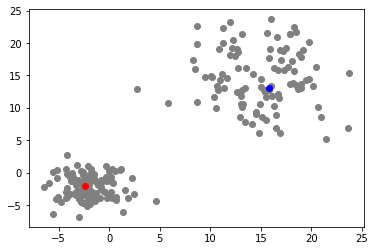

In [11]:
data_colors = ("lightskyblue", "lightpink")
prototype_colors = ("blue", "red")

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color="gray")
for i, v in enumerate(V):
    ax.scatter(v[0], v[1], color=prototype_colors[i])

## StreamSoNG

In [12]:
class StreamSoNG():
    def __init__(self, pknn, sp1m, typicality_threshold, learning_rate=0.1, neighborhood_range=2, num_points_for_new_class=10):
        self.pknn = pknn
        self.sp1m = sp1m
        self.typicality_threshold = typicality_threshold
        self.learning_rate = learning_rate
        self.neighborhood_range = neighborhood_range
        self.num_points_for_new_class = num_points_for_new_class # M
        self.outliers = []
    
    def visualize(self, X, Y, show_radius=False):
        data_colors = ('lightskyblue', 'lightpink', 'mediumspringgreen', 'gold', 'mediumpurple')
        prototype_colors = ('blue', 'red', 'green', 'darkorange', 'darkviolet')

        fig, ax = plt.subplots(figsize=(10, 10))
        
        Y_pred = np.full_like(Y, np.nan)
        for i, (x, j) in enumerate(zip(X, Y)):
            Y_pred[i], typicality_class, _, s_typ, average_typicalities = self.pknn.predict(x, j)

        # data
        for c in range(self.pknn.num_classes):
            indices = np.where(Y_pred == c)
            X_c = X[indices]
            Y_c = Y_pred[indices]
            ax.scatter(X_c[:, 0], X_c[:, 1], label=f"data {c}", color=data_colors[c])

        # prototypes
        for c in range(self.pknn.num_classes):
            indices = np.where(self.pknn.prototype_labels == c)
            prototypes_c = self.pknn.prototypes[indices]
            ax.scatter(prototypes_c[:, 0], prototypes_c[:, 1], c=prototype_colors[c], label=f"prototypes {c}", marker="x")
            if show_radius:
                for i in range(len(prototypes_c)):
                    x = prototypes_c[i, 0]
                    y = prototypes_c[i, 1]
                    circle = plt.Circle((x, y), self.pknn.radius[c], color=prototype_colors[c], fill=False, linestyle="--")
                    ax.add_patch(circle)

        ax.set_aspect(1)
        plt.legend()
        plt.show()
    
    def update(self, k, prototype_idx, typicality_class, x):
        self.pknn.prototypes[prototype_idx] += self.learning_rate * typicality_class * np.exp((-k / self.neighborhood_range)) * (x - self.pknn.prototypes[prototype_idx])
    
    def remove_outliers(self):
        self.outliers.clear()
        
    def stream_process(self, X, Y):
        Y_pred = np.zeros(len(X))
        for t in range(len(X)):
            x = X[t]
            j = Y[t]
            
            class_closest, typicality_class, closest_indices, s_typicalities, _ = self.pknn.predict(x, j)
            Y_pred[t] = class_closest
            if typicality_class > self.typicality_threshold:
                for k, closest_idx in enumerate(closest_indices):
                    self.update(k, closest_idx, typicality_class, x)
            else:
                self.outliers.append(x)
                
                U, V = self.sp1m.process(self.outliers)

                new_cluster_typicalities = U[0]
                num_points_half_typicality = len(np.where(new_cluster_typicalities > 0.5)[0])
                if num_points_half_typicality > self.num_points_for_new_class:
                    print("> NEW CLASS from", num_points_half_typicality, "points")
                    ng = NeuralGas(num_prototypes=num_prototypes, dimension=dimension, step_size=0.01, neighborhood_range=2)
                    X_c = self.outliers
                    Y_c = np.zeros(len(X_c)) + self.pknn.num_classes
                    ng.initialize_prototypes(X_c, Y_c)
                    for epoch in range(20):
                        ng.learn(X_c)
                    self.pknn.add_prototypes(ng.prototypes)
                    self.pknn.add_prototype_labels(ng.prototype_labels)
                    self.pknn.add_class()
                    self.pknn.estimate_radius(n=3)
                    self.pknn.radius
                    self.remove_outliers()

In [13]:
pknn = PKNN(prototypes=prototypes, prototype_labels=prototype_labels, num_classes=C, K=3, fuzzifier=1.5)

In [14]:
sp1m = SP1M(C=1, fuzzifier=2, bandwidth=np.sqrt(2))

In [15]:
streamsong = StreamSoNG(pknn=pknn, sp1m=sp1m, typicality_threshold=0.2, learning_rate=0.5, neighborhood_range=2, num_points_for_new_class=10)

array([3.12707033, 2.4439436 ])

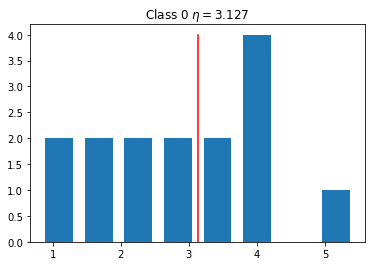

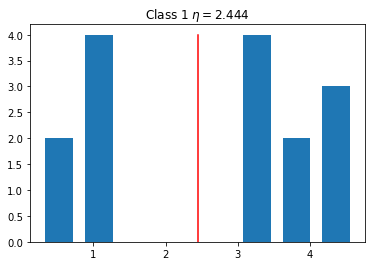

In [16]:
streamsong.pknn.estimate_radius(n=3, show_figure=True)
streamsong.pknn.radius

In [17]:
X_all = X.copy()
Y_all = Y.copy()

In [18]:
X_new = np.random.normal((12, 12), 2, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

300


In [19]:
streamsong.stream_process(X_new, Y_new)

> NEW CLASS from 11 points


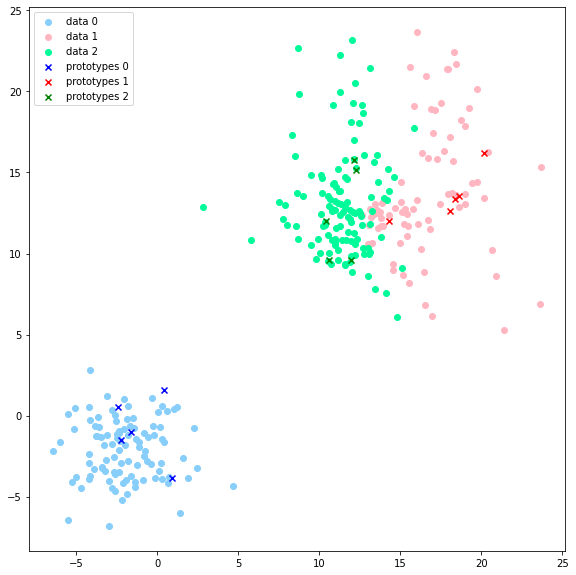

In [20]:
streamsong.visualize(X_all, Y_all)

In [21]:
X_new = np.random.normal((5, 10), 2, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

400


In [22]:
streamsong.stream_process(X_new, Y_new)

> NEW CLASS from 11 points


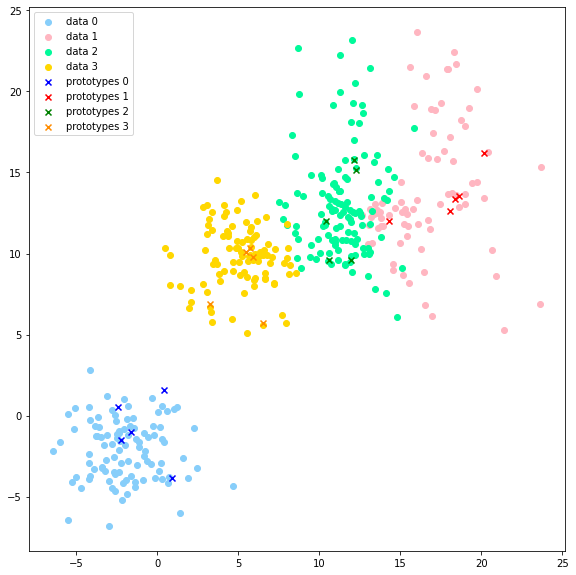

In [23]:
streamsong.visualize(X_all, Y_all)

In [24]:
X_new = np.random.normal((20, 0), 1, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

500


In [25]:
streamsong.stream_process(X_new, Y_new)

> NEW CLASS from 14 points


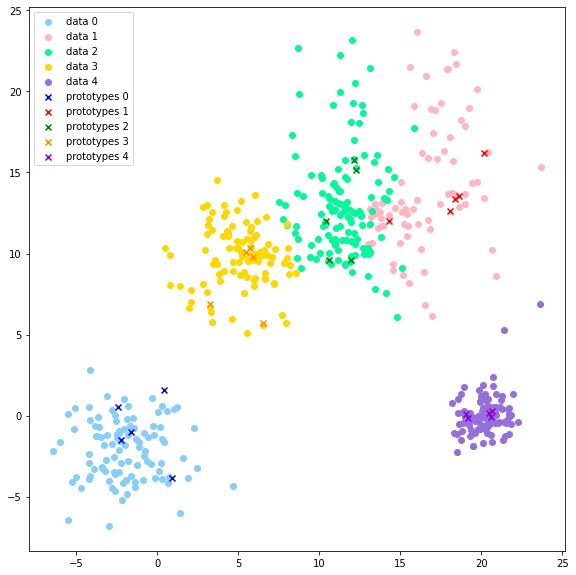

In [26]:
streamsong.visualize(X_all, Y_all)